---
## 1. Setup and Data Loading

In [1]:
# ============================================
# IMPORT LIBRARIES
# ============================================
# We add visualization libraries for EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional look
plt.rcParams['figure.figsize'] = (12, 6)  # Default figure size
plt.rcParams['font.size'] = 11

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

print("✅ Libraries imported")

✅ Libraries imported


In [2]:
# ============================================
# LOAD DATA
# ============================================
# Same raw data as Notebook 00

df = pd.read_csv('../data/raw/Output_10yrs_reported_schools_17220.csv')

# Rename columns for easier reference (consistent naming throughout project)
df = df.rename(columns={
    'Survey Year': 'Year',
    'Institution Name': 'Institution_Name',
    'State CD': 'State',
    'Classification Name': 'Classification'
})

print(f"✅ Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"📅 Years: {df['Year'].min()} - {df['Year'].max()}")

✅ Data loaded: 17,220 rows × 580 columns
📅 Years: 2014 - 2023


---
## 2. Revenue Distribution

**Question:** How is athletic revenue distributed across institutions?

This will help us decide:
- Should we use raw values or transformations (log, growth rates)?
- Are there outliers we need to handle?

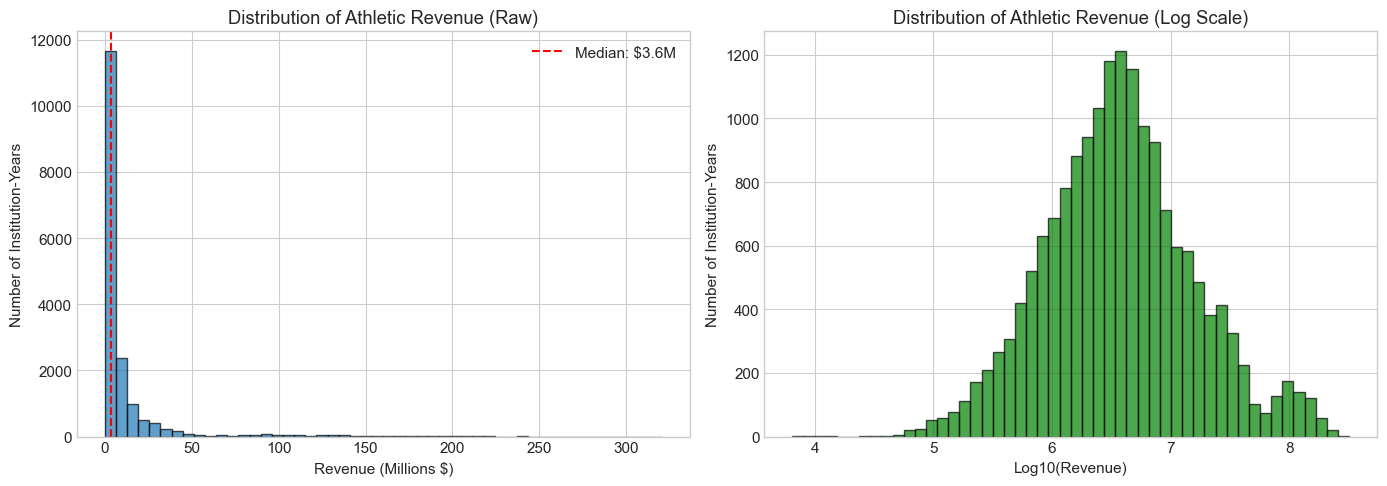


📊 REVENUE STATISTICS:
   Minimum:  $          6,463
   25th %:   $      1,414,800
   Median:   $      3,556,134
   75th %:   $      8,745,982
   Maximum:  $    320,312,665
   Skewness:            4.71


In [3]:
# ============================================
# REVENUE DISTRIBUTION
# ============================================
# Plot histogram to see how revenue is distributed

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Raw distribution (will likely be heavily skewed)
axes[0].hist(df['Grand Total Revenue'] / 1e6, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Revenue (Millions $)')
axes[0].set_ylabel('Number of Institution-Years')
axes[0].set_title('Distribution of Athletic Revenue (Raw)')
axes[0].axvline(df['Grand Total Revenue'].median() / 1e6, color='red', linestyle='--', label=f"Median: ${df['Grand Total Revenue'].median()/1e6:.1f}M")
axes[0].legend()

# Right: Log-transformed (should be more normal)
log_revenue = np.log10(df['Grand Total Revenue'].replace(0, np.nan).dropna())
axes[1].hist(log_revenue, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log10(Revenue)')
axes[1].set_ylabel('Number of Institution-Years')
axes[1].set_title('Distribution of Athletic Revenue (Log Scale)')

plt.tight_layout()
plt.show()

# Print key statistics
print("\n📊 REVENUE STATISTICS:")
print(f"   Minimum:  ${df['Grand Total Revenue'].min():>15,.0f}")
print(f"   25th %:   ${df['Grand Total Revenue'].quantile(0.25):>15,.0f}")
print(f"   Median:   ${df['Grand Total Revenue'].median():>15,.0f}")
print(f"   75th %:   ${df['Grand Total Revenue'].quantile(0.75):>15,.0f}")
print(f"   Maximum:  ${df['Grand Total Revenue'].max():>15,.0f}")
print(f"   Skewness: {df['Grand Total Revenue'].skew():>15,.2f}")

### 📝 Observation 1: Revenue is Heavily Skewed

**What we see:**
- The raw distribution is extremely right-skewed
- Most institutions have relatively small athletic budgets
- A few "mega" programs (likely D1 football schools) dominate the right tail

**Implication for feature engineering:**
- Using raw revenue values would let large schools dominate the model
- We should consider using **growth rates** or **ratios** instead of raw values
- Log transformation makes the distribution more normal

---
## 3. Division Comparison

**Question:** How do financial profiles differ between D1, D2, and D3 schools?

In [4]:
# ============================================
# EXTRACT DIVISION FROM CLASSIFICATION
# ============================================
# Create a simplified Division column for analysis

def extract_division(classification):
    """Extract D1/D2/D3 from full classification name"""
    if pd.isna(classification):
        return 'Unknown'
    if 'NCAA Division I' in classification:
        return 'D1'
    elif 'NCAA Division II' in classification:
        return 'D2'
    elif 'NCAA Division III' in classification:
        return 'D3'
    else:
        return 'Other'

df['Division'] = df['Classification'].apply(extract_division)

print("🏆 INSTITUTIONS BY DIVISION:")
print(df.groupby('Division')['UNITID'].nunique())

🏆 INSTITUTIONS BY DIVISION:
Division
D1         1008
Other       759
Unknown     156
Name: UNITID, dtype: int64


/var/folders/k2/4ym6nvq14tl_bnrkhhxz2gk40000gn/T/ipykernel_97474/3386151466.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot([main_divisions[main_divisions['Division'] == d]['Grand Total Revenue'] / 1e6


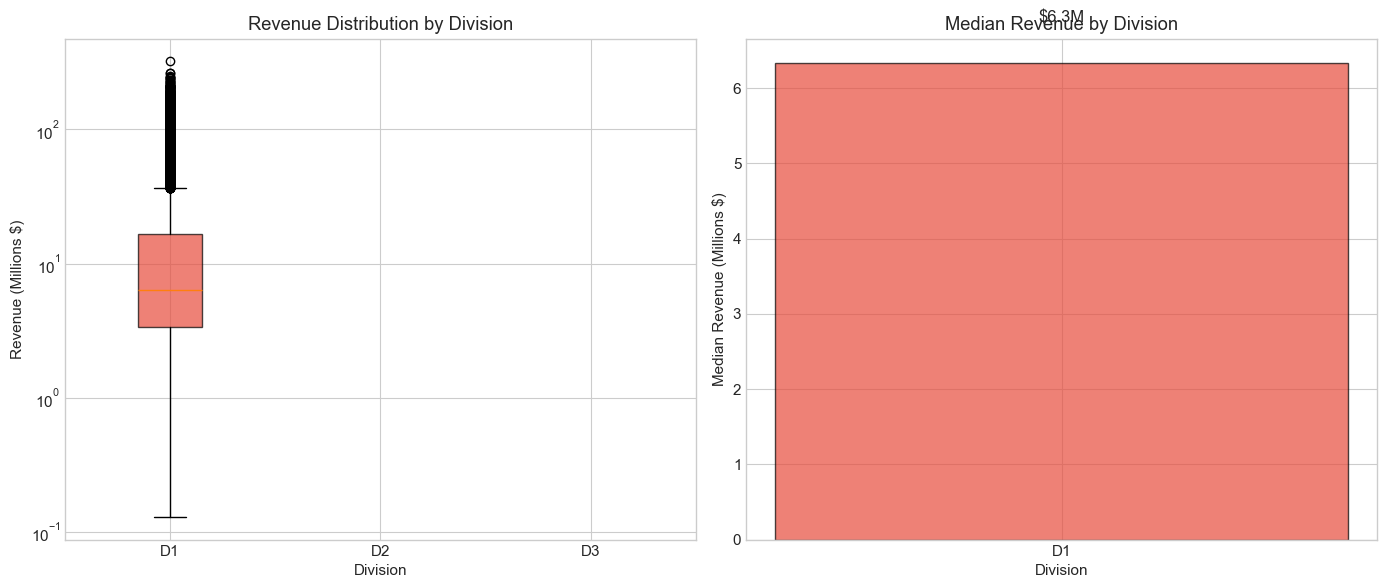


📊 MEDIAN REVENUE BY DIVISION:
   D1: $6,339,265
   D2: $nan
   D3: $nan


In [5]:
# ============================================
# REVENUE BY DIVISION - BOX PLOT
# ============================================
# Compare revenue distributions across divisions

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter to main divisions
main_divisions = df[df['Division'].isin(['D1', 'D2', 'D3'])]

# Left: Box plot of revenue by division
division_order = ['D1', 'D2', 'D3']
colors = ['#e74c3c', '#3498db', '#2ecc71']

bp = axes[0].boxplot([main_divisions[main_divisions['Division'] == d]['Grand Total Revenue'] / 1e6 
                      for d in division_order],
                     labels=division_order, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[0].set_ylabel('Revenue (Millions $)')
axes[0].set_xlabel('Division')
axes[0].set_title('Revenue Distribution by Division')
axes[0].set_yscale('log')  # Log scale to see all divisions

# Right: Median revenue by division (clearer comparison)
median_by_division = main_divisions.groupby('Division')['Grand Total Revenue'].median().reindex(division_order)
bars = axes[1].bar(division_order, median_by_division / 1e6, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Median Revenue (Millions $)')
axes[1].set_xlabel('Division')
axes[1].set_title('Median Revenue by Division')

# Add value labels on bars
for bar, val in zip(bars, median_by_division / 1e6):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'${val:.1f}M', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Print statistics
print("\n📊 MEDIAN REVENUE BY DIVISION:")
for div in division_order:
    med = main_divisions[main_divisions['Division'] == div]['Grand Total Revenue'].median()
    print(f"   {div}: ${med:,.0f}")

### 📝 Observation 2: Huge Differences Between Divisions

**What we see:**
- D1 schools have ~10x the revenue of D2 schools
- D2 schools have ~2-3x the revenue of D3 schools
- D1 has much higher variance (some mega-programs, some smaller D1 schools)

**Implication for feature engineering:**
- Division is a critical feature — it captures huge structural differences
- We may need to normalize by division or use division as a categorical feature
- Models might benefit from division-specific thresholds

---
## 4. Time Trends

**Question:** How have athletic revenues and expenses changed from 2014 to 2023?

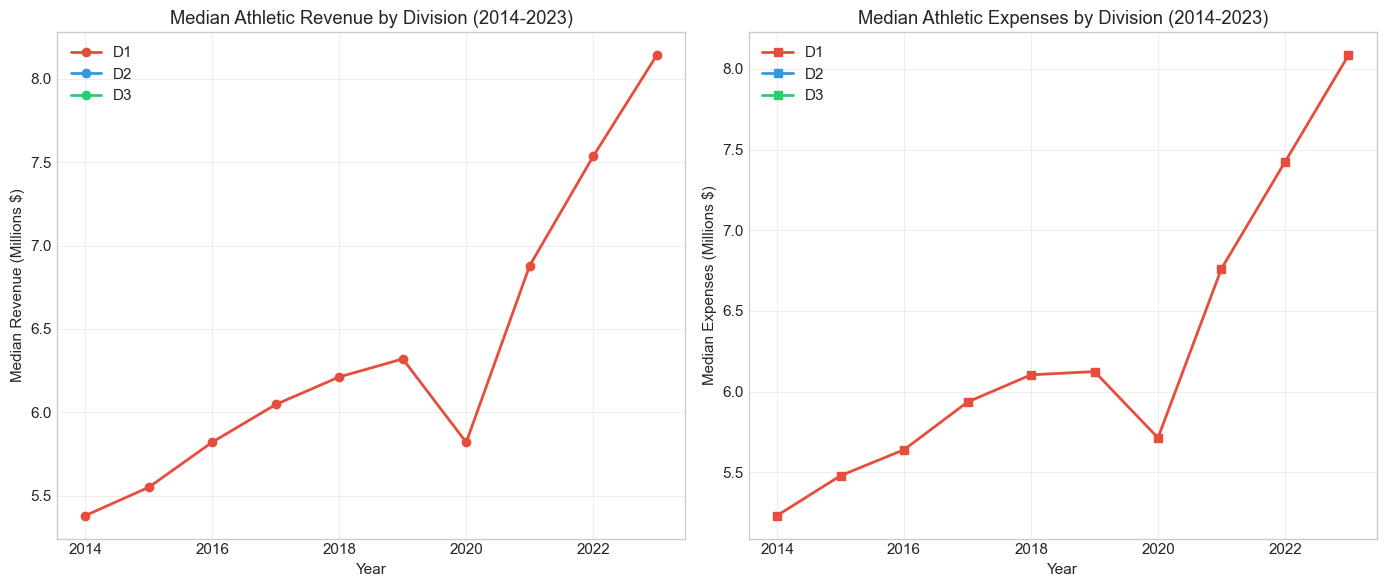

In [6]:
# ============================================
# REVENUE AND EXPENSE TRENDS OVER TIME
# ============================================

# Calculate median by year and division
yearly_stats = df.groupby(['Year', 'Division']).agg({
    'Grand Total Revenue': 'median',
    'Grand Total Expenses': 'median'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

division_colors = {'D1': '#e74c3c', 'D2': '#3498db', 'D3': '#2ecc71'}

# Left: Revenue over time
for div in ['D1', 'D2', 'D3']:
    div_data = yearly_stats[yearly_stats['Division'] == div]
    axes[0].plot(div_data['Year'], div_data['Grand Total Revenue'] / 1e6, 
                 marker='o', label=div, color=division_colors[div], linewidth=2)

axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Revenue (Millions $)')
axes[0].set_title('Median Athletic Revenue by Division (2014-2023)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Expenses over time
for div in ['D1', 'D2', 'D3']:
    div_data = yearly_stats[yearly_stats['Division'] == div]
    axes[1].plot(div_data['Year'], div_data['Grand Total Expenses'] / 1e6, 
                 marker='s', label=div, color=division_colors[div], linewidth=2)

axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Expenses (Millions $)')
axes[1].set_title('Median Athletic Expenses by Division (2014-2023)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

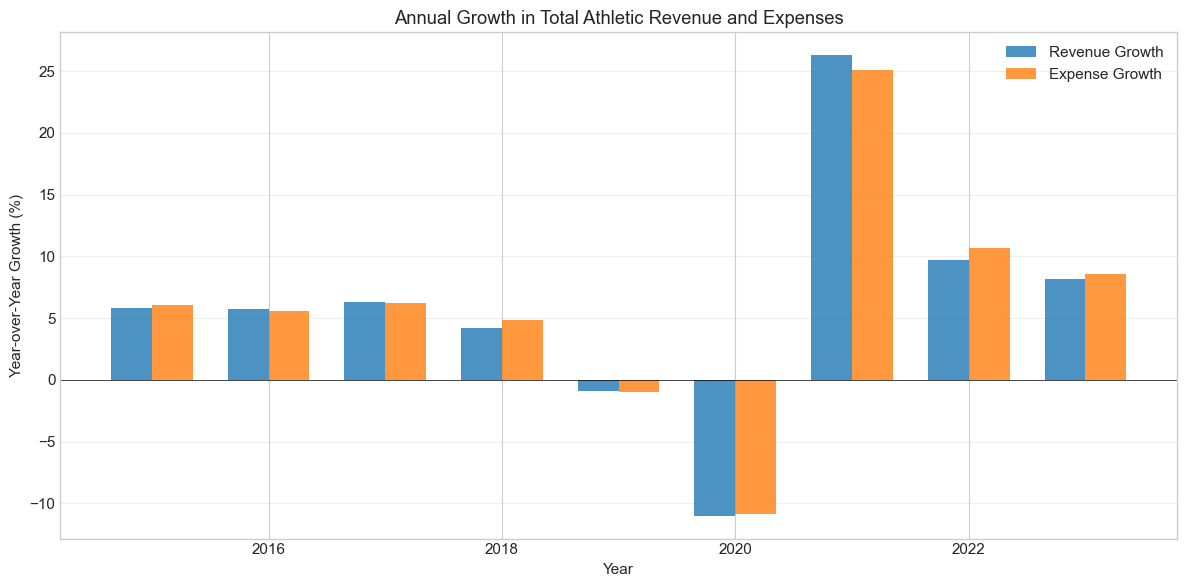


📊 YEAR-OVER-YEAR GROWTH RATES:
 Year  Revenue_Growth  Expense_Growth
 2014             NaN             NaN
 2015            5.79            6.06
 2016            5.77            5.57
 2017            6.30            6.24
 2018            4.19            4.87
 2019           -0.88           -1.00
 2020          -11.00          -10.91
 2021           26.29           25.08
 2022            9.73           10.69
 2023            8.13            8.59


In [7]:
# ============================================
# YEAR-OVER-YEAR GROWTH RATES
# ============================================
# Calculate overall growth rates to see annual patterns

yearly_totals = df.groupby('Year').agg({
    'Grand Total Revenue': 'sum',
    'Grand Total Expenses': 'sum'
}).reset_index()

yearly_totals['Revenue_Growth'] = yearly_totals['Grand Total Revenue'].pct_change() * 100
yearly_totals['Expense_Growth'] = yearly_totals['Grand Total Expenses'].pct_change() * 100

fig, ax = plt.subplots(figsize=(12, 6))

x = yearly_totals['Year'][1:]  # Skip first year (no growth rate)
width = 0.35

bars1 = ax.bar(x - width/2, yearly_totals['Revenue_Growth'][1:], width, label='Revenue Growth', alpha=0.8)
bars2 = ax.bar(x + width/2, yearly_totals['Expense_Growth'][1:], width, label='Expense Growth', alpha=0.8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Year')
ax.set_ylabel('Year-over-Year Growth (%)')
ax.set_title('Annual Growth in Total Athletic Revenue and Expenses')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 YEAR-OVER-YEAR GROWTH RATES:")
print(yearly_totals[['Year', 'Revenue_Growth', 'Expense_Growth']].to_string(index=False))

### 📝 Observation 3: Growth Trends and COVID Impact

**What we see:**
- Generally positive growth in both revenue and expenses over time
- Likely a dip around 2020-2021 (COVID-19 impact)
- Revenue and expenses tend to move together

**Implication for feature engineering:**
- Growth rates capture meaningful information about financial health
- Multi-year trends (CAGR) might be more stable than 1-year growth
- Year itself is NOT a feature (we're predicting the future, not explaining the past)

---
## 5. Revenue-to-Expense Relationship

**Question:** How do revenue and expenses relate to each other?

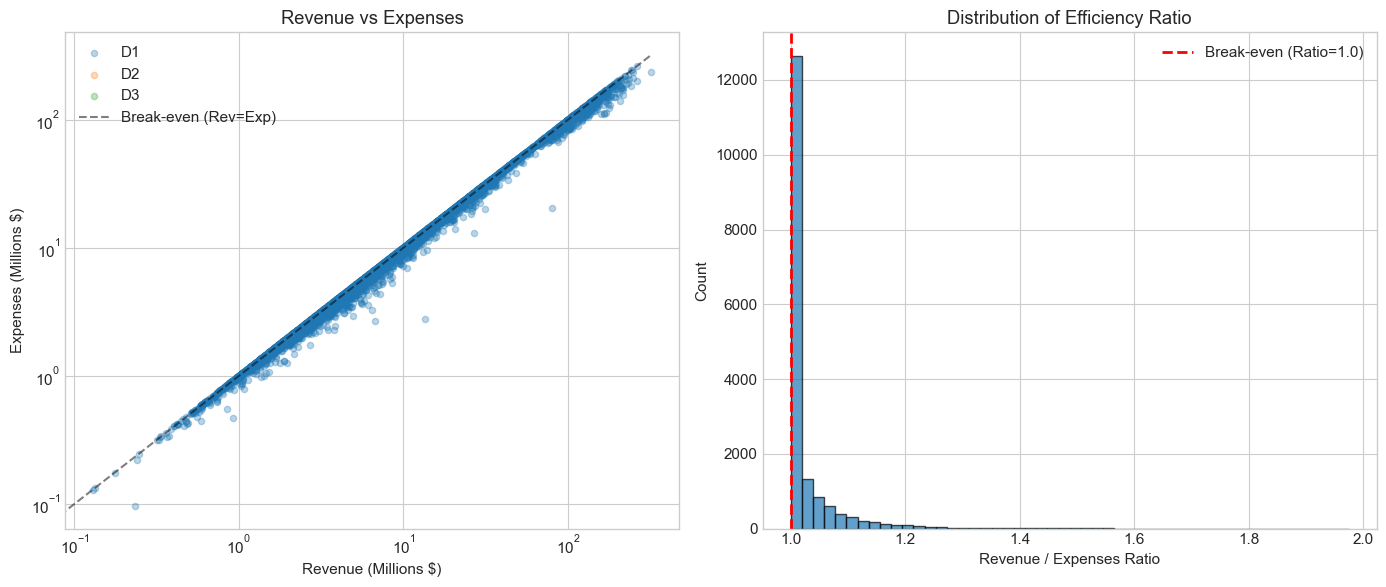


📊 EFFICIENCY RATIO (Revenue/Expenses) STATISTICS:
   Mean:         1.027
   Median:       1.000
   % at exactly 1.0: 59.9%


In [8]:
# ============================================
# REVENUE VS EXPENSES SCATTER PLOT
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Scatter plot (log scale)
main_divisions = df[df['Division'].isin(['D1', 'D2', 'D3'])]

for div in ['D1', 'D2', 'D3']:
    div_data = main_divisions[main_divisions['Division'] == div]
    axes[0].scatter(div_data['Grand Total Revenue'] / 1e6, 
                    div_data['Grand Total Expenses'] / 1e6,
                    alpha=0.3, label=div, s=20)

# Add y=x line (break-even)
max_val = max(main_divisions['Grand Total Revenue'].max(), main_divisions['Grand Total Expenses'].max()) / 1e6
axes[0].plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Break-even (Rev=Exp)')

axes[0].set_xlabel('Revenue (Millions $)')
axes[0].set_ylabel('Expenses (Millions $)')
axes[0].set_title('Revenue vs Expenses')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

# Right: Efficiency Ratio Distribution
df['Efficiency_Ratio'] = df['Grand Total Revenue'] / df['Grand Total Expenses'].replace(0, np.nan)

# Filter to reasonable range for visualization
valid_efficiency = df['Efficiency_Ratio'].dropna()
valid_efficiency = valid_efficiency[(valid_efficiency > 0.5) & (valid_efficiency < 2)]

axes[1].hist(valid_efficiency, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Break-even (Ratio=1.0)')
axes[1].set_xlabel('Revenue / Expenses Ratio')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Efficiency Ratio')
axes[1].legend()

plt.tight_layout()
plt.show()

# Statistics on efficiency ratio
print("\n📊 EFFICIENCY RATIO (Revenue/Expenses) STATISTICS:")
print(f"   Mean:         {df['Efficiency_Ratio'].mean():.3f}")
print(f"   Median:       {df['Efficiency_Ratio'].median():.3f}")
print(f"   % at exactly 1.0: {(df['Efficiency_Ratio'] == 1.0).mean() * 100:.1f}%")

### 📝 Observation 4: Revenue and Expenses are Highly Correlated

**What we see:**
- Revenue and expenses are almost perfectly correlated
- Most institutions hover around break-even (ratio ≈ 1.0)
- A suspicious number of institutions report EXACTLY 1.0 ratio (possible accounting practice)

**Implication for feature engineering:**
- The efficiency ratio captures financial health better than raw values
- We should flag "exactly 1.0" reporters as potential data quality issue
- Changes in efficiency ratio over time might be predictive

---
## 6. Correlation Analysis

**Question:** Which variables are related to each other?

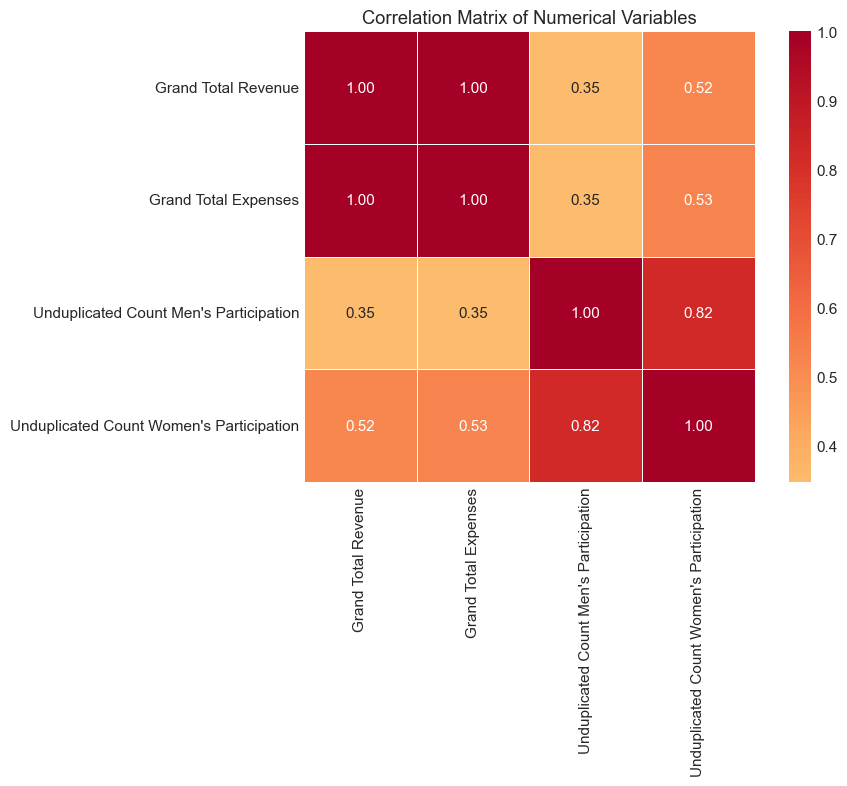

In [9]:
# ============================================
# CORRELATION MATRIX
# ============================================

# Select numerical columns for correlation
numerical_cols = [
    'Grand Total Revenue', 
    'Grand Total Expenses',
    "Unduplicated Count Men's Participation",
    "Unduplicated Count Women's Participation"
]

# Filter to existing columns
available_cols = [col for col in numerical_cols if col in df.columns]

# Calculate correlation matrix
corr_matrix = df[available_cols].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

### 📝 Observation 5: Strong Correlations Between Financials and Participation

**What we see:**
- Revenue and Expenses: ~0.99 correlation (almost identical)
- Athlete count correlates with financial size
- Men's and Women's participation are correlated

**Implication for feature engineering:**
- Revenue per athlete might be a useful normalized metric
- Total athletes is a scale indicator

---
## 7. Outlier Detection

**Question:** Are there anomalous values we should be aware of?

In [10]:
# ============================================
# IDENTIFY EXTREME VALUES
# ============================================

# Top 10 institutions by revenue (single year)
top_revenue = df.nlargest(10, 'Grand Total Revenue')[['Institution_Name', 'Year', 'Grand Total Revenue', 'Division']]

print("💰 TOP 10 HIGHEST REVENUE INSTITUTION-YEARS:")
print("=" * 80)
for _, row in top_revenue.iterrows():
    print(f"{row['Institution_Name']:<40} {row['Year']}  ${row['Grand Total Revenue']:>15,.0f}  ({row['Division']})")

💰 TOP 10 HIGHEST REVENUE INSTITUTION-YEARS:
The University of Texas at Austin        2023  $    320,312,665  (D1)
Ohio State University-Main Campus        2023  $    262,172,467  (D1)
The University of Texas at Austin        2022  $    261,353,404  (D1)
Ohio State University-Main Campus        2022  $    249,698,974  (D1)
Ohio State University-Main Campus        2021  $    246,605,307  (D1)
The University of Alabama                2023  $    243,096,720  (D1)
University of Southern California        2023  $    242,378,198  (D1)
University of Georgia                    2023  $    241,843,474  (D1)
University of Notre Dame                 2023  $    234,746,127  (D1)
Texas A & M University-College Station   2023  $    231,773,287  (D1)


In [11]:
# ============================================
# CHECK FOR ZERO OR NEGATIVE VALUES
# ============================================

print("⚠️ DATA QUALITY CHECK:")
print("=" * 50)
print(f"Rows with zero revenue:    {(df['Grand Total Revenue'] == 0).sum():,}")
print(f"Rows with zero expenses:   {(df['Grand Total Expenses'] == 0).sum():,}")
print(f"Rows with ratio exactly 1: {(df['Efficiency_Ratio'] == 1.0).sum():,}")
print(f"\nPercentage 'exactly 1.0':  {(df['Efficiency_Ratio'] == 1.0).mean() * 100:.1f}%")

⚠️ DATA QUALITY CHECK:
Rows with zero revenue:    0
Rows with zero expenses:   0
Rows with ratio exactly 1: 10,315

Percentage 'exactly 1.0':  59.9%


### 📝 Observation 6: Data Quality Flag Needed

**What we see:**
- A notable percentage of institutions report Revenue = Expenses exactly
- This is likely an accounting practice, not true financial performance

**Implication for feature engineering:**
- Create a flag: `Reports_Exactly_One = 1` if Efficiency_Ratio == 1.0
- This can help the model distinguish these cases

---
## 8. Volatility Analysis

**Question:** How stable are financial metrics over time for individual institutions?

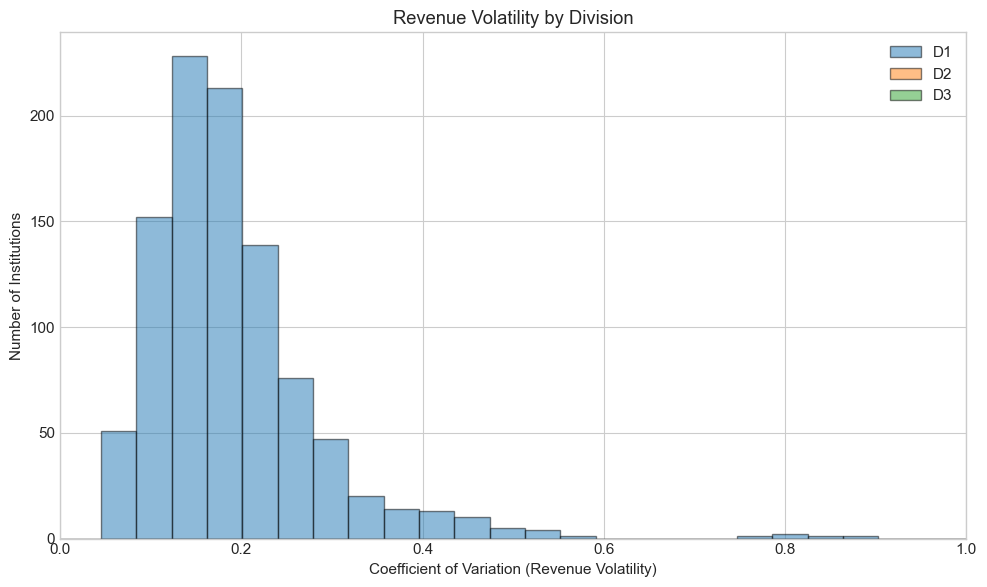


📊 MEDIAN VOLATILITY BY DIVISION:
   D1: 0.173
   D2: nan
   D3: nan


In [12]:
# ============================================
# CALCULATE REVENUE VOLATILITY BY INSTITUTION
# ============================================
# Coefficient of Variation = StdDev / Mean
# Higher values = more volatile

institution_volatility = df.groupby('UNITID').agg({
    'Grand Total Revenue': ['mean', 'std'],
    'Institution_Name': 'first',
    'Division': 'first'
}).reset_index()

institution_volatility.columns = ['UNITID', 'Revenue_Mean', 'Revenue_Std', 'Institution_Name', 'Division']
institution_volatility['CV'] = institution_volatility['Revenue_Std'] / institution_volatility['Revenue_Mean']

# Distribution of CV by division
fig, ax = plt.subplots(figsize=(10, 6))

for div in ['D1', 'D2', 'D3']:
    div_data = institution_volatility[institution_volatility['Division'] == div]['CV'].dropna()
    ax.hist(div_data, bins=30, alpha=0.5, label=div, edgecolor='black')

ax.set_xlabel('Coefficient of Variation (Revenue Volatility)')
ax.set_ylabel('Number of Institutions')
ax.set_title('Revenue Volatility by Division')
ax.legend()
ax.set_xlim(0, 1)  # Focus on reasonable range

plt.tight_layout()
plt.show()

print("\n📊 MEDIAN VOLATILITY BY DIVISION:")
for div in ['D1', 'D2', 'D3']:
    median_cv = institution_volatility[institution_volatility['Division'] == div]['CV'].median()
    print(f"   {div}: {median_cv:.3f}")

### 📝 Observation 7: Volatility Varies by Division

**What we see:**
- Revenue volatility (CV) captures how stable an institution's finances are
- Different divisions may have different volatility patterns

**Implication for feature engineering:**
- Rolling volatility (2-year window) could be a useful feature
- Captures financial stability/instability

---
## Summary of EDA Observations

Here's what we learned and how it will guide our feature engineering:

In [13]:
# ============================================
# SUMMARY OF OBSERVATIONS
# ============================================

observations = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                        EDA OBSERVATIONS SUMMARY                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  OBSERVATION 1: Revenue is Heavily Skewed                                    ║
║  → Implication: Use growth rates, not raw values                             ║
║                                                                              ║
║  OBSERVATION 2: Huge Differences Between Divisions                           ║
║  → Implication: Division is a critical categorical feature                   ║
║                                                                              ║
║  OBSERVATION 3: Growth Trends Over Time                                      ║
║  → Implication: Growth rates and CAGR capture meaningful patterns            ║
║                                                                              ║
║  OBSERVATION 4: Revenue and Expenses are Highly Correlated                   ║
║  → Implication: Efficiency ratio is more informative than raw values         ║
║                                                                              ║
║  OBSERVATION 5: Financial Size Correlates with Participation                 ║
║  → Implication: Revenue per athlete is a useful normalized metric            ║
║                                                                              ║
║  OBSERVATION 6: Many Report Exactly 1.0 Efficiency Ratio                     ║
║  → Implication: Create a data quality flag for these cases                   ║
║                                                                              ║
║  OBSERVATION 7: Volatility Varies by Institution                             ║
║  → Implication: Rolling volatility captures financial stability              ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝

NEXT STEP: Translate these observations into specific feature ideas
→ Proceed to 02_Feature_Discovery.ipynb
"""

print(observations)


╔══════════════════════════════════════════════════════════════════════════════╗
║                        EDA OBSERVATIONS SUMMARY                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  OBSERVATION 1: Revenue is Heavily Skewed                                    ║
║  → Implication: Use growth rates, not raw values                             ║
║                                                                              ║
║  OBSERVATION 2: Huge Differences Between Divisions                           ║
║  → Implication: Division is a critical categorical feature                   ║
║                                                                              ║
║  OBSERVATION 3: Growth Trends Over Time                                      ║
║  → Implication: Growth rates and CAGR capture meaningful patterns            ║
║                          

---
## ✅ Checkpoint Complete

We've explored the data and identified key patterns:
1. Revenue is skewed → use growth rates
2. Divisions are very different → use Division as feature
3. Efficiency ratio is informative
4. Volatility captures stability
5. Data quality flags are needed

**Next Notebook:** `02_Feature_Discovery.ipynb`  
We'll translate these observations into specific features with clear justifications.